In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
""" Semilla """
seed = 99

## ALGUNAS UTILIDADES SOBRE EL MANEJO DE

# 1. Cargar el dataset
#data = sns.load_dataset("titanic")


Número de filas: 891, Número de columnas:13


<Axes: >

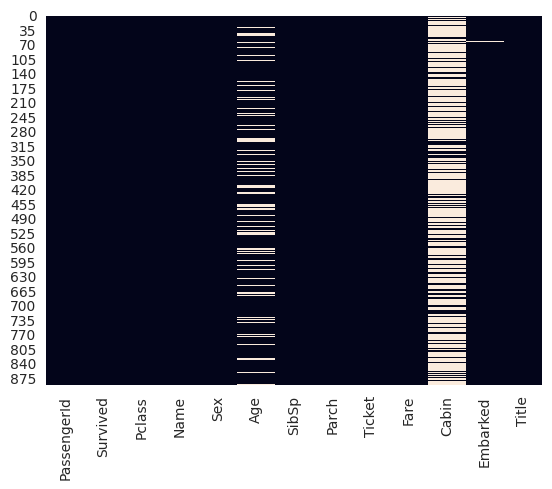

In [2]:

data = pd.read_excel( "titanic.xlsx")
data = data.drop(data.columns[0], axis=1) # eliminamos la primera columna que no tiene sentido

print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}')
data.head()
data.dtypes

###########################################################################
## Paso 1 ## Missing
## Paso 1. vemos cuantos missing tenemos en cada variable ##
data.isnull().sum()

import seaborn as sns
# Identificamos los missing values visualmente
sns.heatmap(data.isnull(), cbar=False)
## vemos que edad, cabin y Embarked tienen valores perdidos. Cabin tiene muchos valores perdidos
## df.fillna(df.mean(), inplace=True)

In [5]:
###########################################################################
## Paso 2 Codificacion, Imputación, o eliminacion de datos perdidos
## en ocasiones la información relevante es si se ha perdido un dato o no
## en otros casos merece la pena imputar su valor mientras que otras veces merece la pena eliminarlo

###############################################
## 2.1 Modificacion de la variable Cabin

#Se llenan los valores nulos (NaN) de la columna 'Cabin' de data con el valor 0.
data['Cabin'] = data['Cabin'].fillna(0)
#Nueva columna hasCabin, que toma valores binarios 0 y 1, en función de si el pasajero tiene o no un número de cabina.
# La función lambda define que si el valor de "Cabin" es 0 el valor de la columna hasCabin toma valor 0,
# en caso contrario toma  valor 1.
data['hasCabin'] = data['Cabin'].apply(lambda x: 0 if x==0 else 1)

#Se eliminan de data las columnas 'PassengerId', 'Name', 'Cabin', 'Ticket'
data = data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])


key_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']

data.head()
### Paso xx. Esto es solo para ver algunas modificaciones que podriamos hacer a la base de datos.
## algunas modificaciones que pueden ser interesantes
#Se pide en esta celda, modificar las variables Title, Parch y SibSp, donde Title tome solo los valores Mr, Mrs, Miss y Otros;
# Parch y SibSp toman solo los valores 0, 1 o 2 (donde 2 incluye 2 o más).
#

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked Title  \
0         0       3    male  22.0      1      0   7.2500        S    Mr   
1         1       1  female  38.0      1      0  71.2833        C   Mrs   
2         1       3  female  26.0      0      0   7.9250        S  Miss   
3         1       1  female  35.0      1      0  53.1000        S   Mrs   
4         0       3    male  35.0      0      0   8.0500        S    Mr   

   hasCabin  
0         0  
1         1  
2         0  
3         1  
4         0

In [6]:

data['SibSp'] = data.SibSp.apply(lambda x: 2 if x>=2 else x)
data['Parch'] = data.Parch.apply(lambda x: 2 if x>=2 else x)
# La función lambda define que si el valor de "Title" es uno de estos tres ['Mr','Mrs','Miss'],
# se mantendrá el valor original. De lo contrario, se reemplazará con el valor "Otros".
data['Title'] = data.Title.apply(lambda x: x if x in ['Mr','Mrs','Miss'] else 'Otros')


# Se eliminan las 2 filas que tienen valores nulos (NaN) en esta columna.
data = data[~data.Embarked.isnull()]
# Se eliminan todos los duplicados.
data = data.drop_duplicates(inplace=False)

In [ ]:
contingency_matrix = pd.crosstab(data['hasCabin'], data['Survived'])

# Imprime la matriz de contingencia
print(contingency_matrix)


# Probabilidad de supervivencia con cabina (hasCabin = 1)
prob_survival_with_cabin = contingency_matrix.loc[1, 1] / contingency_matrix.loc[1].sum()

# Probabilidad de supervivencia sin cabina (hasCabin = 0)
prob_survival_without_cabin = contingency_matrix.loc[0, 1] / contingency_matrix.loc[0].sum()

# Imprime las probabilidades
print(f"Probabilidad de supervivencia con cabina: {prob_survival_with_cabin}")
print(f"Probabilidad de supervivencia sin cabina: {prob_survival_without_cabin}")

Survived    0    1
hasCabin          
0         396  190
1          68  133
Probabilidad de supervivencia con cabina: 0.6616915422885572
Probabilidad de supervivencia sin cabina: 0.3242320819112628


In [ ]:
import scipy.stats as stats

# Calcula la prueba de chi-cuadrado
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_matrix)

# Calcula el coeficiente V de Cramer
n = contingency_matrix.sum().sum()  # Tamaño total de la muestra
phi2 = chi2_stat / n
v_cramer = np.sqrt(phi2 / min(contingency_matrix.shape[0] - 1, contingency_matrix.shape[1] - 1))

print(f"Chi-cuadrado: {chi2_stat:.2f}, p-valor: {p_val:.3f}")
print(f"V de Cramer: {v_cramer:.3f}")

odds_ratio = (contingency_matrix.loc[1, 1] * contingency_matrix.loc[0, 0]) / (contingency_matrix.loc[1, 0] * contingency_matrix.loc[0, 1])
print(f"Odds ratio: {odds_ratio:.2f}")

Chi-cuadrado: 69.05, p-valor: 0.000
V de Cramer: 0.296
Odds ratio: 4.08


In [ ]:

# Define las variables categóricas y la variable objetivo
categorical_vars = ['Pclass', 'Sex', 'Embarked', 'Title', 'hasCabin', 'SibSp', 'Parch']
target_var = 'Survived'

# Crea un diccionario para almacenar los resultados
results = {}

# Itera sobre las variables categóricas
for var in categorical_vars:
    # Crea la matriz de contingencia
    contingency_matrix = pd.crosstab(data[var], data[target_var])
    print(f"Matriz de contingencia para {var}:")
    print(contingency_matrix)
    # Calcula la prueba de chi-cuadrado
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_matrix)

    # Calcula el coeficiente V de Cramer
    n = contingency_matrix.sum().sum()
    phi2 = chi2_stat / n
    v_cramer = np.sqrt(phi2 / min(contingency_matrix.shape[0] - 1, contingency_matrix.shape[1] - 1))

    # Almacena los resultados en el diccionario
    results[var] = {'chi2_stat': chi2_stat, 'p_val': p_val, 'v_cramer': v_cramer}

# Crea un DataFrame a partir de los resultados
results_df = pd.DataFrame.from_dict(results, orient='index')


Matriz de contingencia para Pclass:
Survived    0    1
Pclass            
1          79  133
2          82   85
3         303  105
Matriz de contingencia para Sex:
Survived    0    1
Sex               
female     77  217
male      387  106
Matriz de contingencia para Embarked:
Survived    0    1
Embarked          
C          65   90
Q          39   21
S         360  212
Matriz de contingencia para Title:
Survived    0    1
Title             
Miss       51  115
Mr        355   79
Mrs        26   96
Otros      32   33
Matriz de contingencia para hasCabin:
Survived    0    1
hasCabin          
0         396  190
1          68  133
Matriz de contingencia para SibSp:
Survived    0    1
SibSp             
0         322  196
1          94  108
2          48   19
Matriz de contingencia para Parch:
Survived    0    1
Parch             
0         366  216
1          51   63
2          47   44


In [ ]:
display(results_df)

chi2_stat         p_val  v_cramer
Pclass     87.441870  1.028583e-19  0.333328
Sex       206.097794  9.755596e-47  0.511740
Embarked   23.209198  9.124029e-06  0.171729
Title     222.246859  6.561556e-48  0.531411
hasCabin   69.047722  9.610949e-17  0.296202
SibSp      19.536530  5.723957e-05  0.157557
Parch      15.249593  4.881946e-04  0.139201

In [ ]:
# Combinar hasCabin con Pclass
data['Cabin_Sex'] = data['hasCabin'].astype(str) + '_' + data['Sex'].astype(str)

# Calcular la prueba de chi-cuadrado
contingency_matrix = pd.crosstab(data['Cabin_Sex'], data['Survived'])
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_matrix)

print(f"Chi-cuadrado para Cabin_Pclass: {chi2_stat:.2f}, p-valor: {p_val:.3f}")
print(contingency_matrix)

Chi-cuadrado para Cabin_Pclass: 254.52, p-valor: 0.000
Survived     0    1
Cabin_Sex          
0_female    71  129
0_male     325   61
1_female     6   88
1_male      62   45


In [ ]:
display(data)

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Title  \
0           0       3    male  22.0      1      0   7.2500        S     Mr   
1           1       1  female  38.0      1      0  71.2833        C    Mrs   
2           1       3  female  26.0      0      0   7.9250        S   Miss   
3           1       1  female  35.0      1      0  53.1000        S    Mrs   
4           0       3    male  35.0      0      0   8.0500        S     Mr   
..        ...     ...     ...   ...    ...    ...      ...      ...    ...   
886         0       2    male  27.0      0      0  13.0000        S  Otros   
887         1       1  female  19.0      0      0  30.0000        S   Miss   
888         0       3  female   NaN      1      2  23.4500        S   Miss   
889         1       1    male  26.0      0      0  30.0000        C     Mr   
890         0       3    male  32.0      0      0   7.7500        Q     Mr   

     hasCabin Cabin_Sex  
0           0    0_male  
1           1  1_female  
2           0  0_female  
3           1  1_female  
4           0    0_male  
..        ...       ...  
886         0    0_male  
887         1  1_female  
888         0  0_female  
889         1    1_male  
890         0    0_male  

[787 rows x 11 columns]

In [ ]:
############################################3
###### 2.2 imputacion de datos perdidos
imputer = KNNImputer(n_neighbors=3, metric='nan_euclidean')
# Imputamos los valores perdidos en el DataFrame
## Para imputar con Knn necesitamos tranformar las variables en numeros
le = LabelEncoder()
# Codificamos las variables categóricas como numéricas
data_enco=data

for col in data_enco.columns:
    if data_enco[col].dtype == 'object':  # Si la columna contiene valores categóricos
        le = LabelEncoder()         # Creamos una instancia de LabelEncoder
        data_enco[col] = le.fit_transform(data_enco[col])  # Codificamos la columna como numérica

## ahora podemos inputar por ejemplo con el KNN

data_imputed = pd.DataFrame(imputer.fit_transform(data_enco))
## recuperamos los nombres y tenemos  nuestra base de datos depurada
data_imputed=data_imputed.set_axis([key_cols], axis=1)
## datos sin missing y encoder


LR: 0.791610 (0.030651)
LDA: 0.789111 (0.039198)
KNN: 0.752223 (0.059997)
DTC: 0.728043 (0.040932)
NB: 0.754836 (0.021927)
RFC: 0.763681 (0.050615)
SVM: 0.798004 (0.038005)


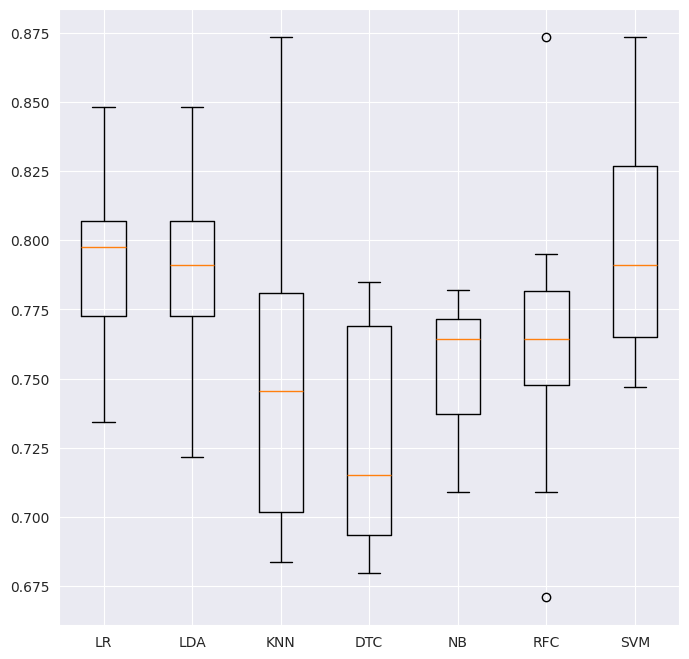

In [ ]:

#ColumnTransformer: aplica diferentes transformaciones a diferentes columnas de data y
#generar un nuevo DataFrame "Transformed data".
transformer1 = [
    ('KNNImputer', KNNImputer(n_neighbors=5,  weights='uniform', metric='nan_euclidean'), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
    ('PowerTransformerYJ', PowerTransformer(method='yeo-johnson'), ['Fare']),
    ('encoder1', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('encoder2', OneHotEncoder(drop='first'), ['Embarked']),
    ('encoder3', OneHotEncoder(), ['Title']),
    ('encoder4', OneHotEncoder(), ['Parch'])
]

transformer2= [
    ('KNNImputer', KNNImputer(n_neighbors=5,  weights='uniform', metric='nan_euclidean'), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),

]

col_transformer = ColumnTransformer(transformer1, remainder='drop')

#KNNImputer :  técnica de imputación de valores faltantes que utiliza el algoritmo de los k vecinos más cercanos
#para estimar los valores faltantes basándose en los valores de las columnas cercanas.

#PowerTransformer: transforma las variables numéricas
# con el objetivo de mejorar la distribución y normalidad de los datos.

#OneHotEncoder: transformar una variable categórica  en una representación numérica binaria.

#remainder=drop, por lo que las columnas no transformadas se eliminan del conjunto de datos transformado.

ctransformed = col_transformer.fit_transform(data)

##############pipeline para modelos de ML

models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))

X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']]
y = data['Survived']

def boxplots_algorithms(results, names):

    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

###############

results = []
names = []

for name, model in models:
    scaler = RobustScaler()
    pipeline = make_pipeline(col_transformer, scaler, model)
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

boxplots_algorithms(results, names)

# • Pipeline : Encadena múltiples pasos (ColumnTransformer, RobustScaler y el Modelo);
# la salida de cada paso se usa como entrada para el siguiente paso.
# • Validación cruzada : Kfold se utiliza para dividir los datos  en 10 carpetas y en cada iteración utiliza uno
# de estos carpetas como conjunto de prueba y los demás como conjunto de entrenamiento. El argumento shuffle=True
# indica que los datos se mezclarán antes de dividirlos en pliegues y random_state=seed para que la división sea
# determinista y reproducible. cross_val_score para realizar la validación cruzada y obtener el score de cada modelo.

# SVM es el mejor modelo, con un score de 0.7980
